# Differentiable Least Squares PyTorch Worked Example

In this notebook we develop a node to implement a differentiable least-squares node. The inputs
to the node are a set of feature vectors and corresponding target values

$$
\{(x_i, t_i) \in \mathbb{R}^n \times \mathbb{R} \mid i = 1, \ldots, m\}.
$$

For simplicity of exposition we'll represent the input feactures by a matrix $X$ with $m$ rows and $n$ columns (i.e., each **row** represents the feature vector $x_i^T$). Similarly, the target values will be represented as an $m$-length vector $t$.
Note that the number of rows can vary from instance to instance, i.e., we are not restricted to fixed length sets, while the output stays fixed-length akin to a global pooling operation.

The node computes the output by solving the following regularized least-squares regression problem,
$$
y, y_0 = \text{argmin}_{u, u_0} \frac{1}{2} \| X u + u_0 - t \|_2^2 + \frac{\beta}{2} \|u\|_2^2
$$

Here $u_0 \in \mathbb{R}$ is a bias term that allows for shifting the mean of the data.

## Closed form solution

The solution to this problem can be written in closed form as

$$
(y, y_0) = \left(A^T A\right)^{-1} A^T b
$$

where

$$
A = \begin{bmatrix}
X & 1_m \\ \sqrt{\beta} I & 0_n
\end{bmatrix}
\quad
\text{and}
\quad
b = \begin{bmatrix}
t \\ 0_n
\end{bmatrix}.
$$

## Gradients

We now consider differentiating $y$ with respect to each $x_i$. Given that we have a closed form solution for $y$ we can differentiate this directly. For an individual element $x_{ij}$ this gives

$$
\begin{align}
\frac{d}{d x_{ij}} \begin{bmatrix} y \\ y_0 \end{bmatrix}
&= \frac{d}{d x_{ij}} \left(A^TA\right)^{-1} A^T b \\
&= -(A^TA)^{-1} \left(\frac{d}{d x_{ij}} A^TA\right) (A^TA)^{-1} A^T b + (A^TA)^{-1} \left(\frac{d}{d x_{ij}} A^T \right) b \\
&= -(A^TA)^{-1} \left(
    \left(\frac{d}{d x_{ij}} A^T\right) \left(A \begin{bmatrix} y \\ y_0 \end{bmatrix} - b\right) + A^T \left(\frac{d}{d x_{ij}} A\right) \begin{bmatrix} y \\ y_0 \end{bmatrix}
\right) \\
&= -(A^TA)^{-1} \left( E_{ji} \left(A \begin{bmatrix} y \\ y_0 \end{bmatrix} - b \right) + A^T E_{ij} \begin{bmatrix} y \\ y_0 \end{bmatrix} \right) \\
&= -(A^TA)^{-1} \left( (x_i^T y + y_0 - t_i) \begin{bmatrix} e_j \\ 0 \end{bmatrix} + y_j \begin{bmatrix} x_i \\ 1 \end{bmatrix} \right)
\end{align}
$$
where $e_j = (0, 0, \ldots, 1, 0, \ldots) \in \mathbb{R}^n$ is the $j$-th canonical vector.

An alternative is to consider differentiation by thinking of rank pooling as a deep declarative node. We have objective function

$$
f(X, u, u_0) = \frac{1}{2} \sum_{j=1}^{m} \left(x_j^T u + u_0 - t_j\right)^2 + \frac{\beta}{2} \|u\|_2^2
$$

where $u \in \mathbb{R}^n$ and $u_0 \in \mathbb{R}$, and which we want to differentiate with respect to each $x_i \in \mathbb{R}^n$.

From ["Deep Declarative Networks" (Gould et al., 2019)](https://arxiv.org/abs/1909.04866) we have

$$
\text{D} \begin{bmatrix} y(x_i) \\ y_0(x_i) \end{bmatrix} = -H^{-1} B
$$

where

$$
\begin{align*}
H &= \begin{bmatrix}
    \text{D}_{YY}^2 f & \text{D}_{Y_0Y}^2 f \\ \text{D}_{YY_0}^2 f & \text{D}_{Y_0Y_0}^2 f
\end{bmatrix}
= \begin{bmatrix}
    \sum_{j=1}^{m} x_j x_j^T + \beta I & \sum_{j=1}^{m} x_j \\ \sum_{j=1}^{m} x_j^T & m
\end{bmatrix}
= A^T A
\\
B &= \begin{bmatrix} 
    \text{D}_{X_iY}^2 f \\ \text{D}_{X_iY_0}^2 f
\end{bmatrix}
=
\begin{bmatrix}
    (x_i^T y + y_0 - t_i) I + x_i y^T \\
    y^T
\end{bmatrix}
\end{align*}
$$

Note here that $H \in \mathbb{R}^{(n+1) \times (n+1)}$ and $B \in \mathbb{R}^{(n+1) \times n}$. Moreover, while this calculation needs to be computed for each $x_i$ the matrix $H$ is independent of $i$ (and, unsurprisingly, $y$ since $f$ is quadratic). Usually we will only care about $\text{D} y(x_i)$, such as when the ultimate loss function $J$ does not depend on $y_0$. Let $v^T = \text{D} J(y) \in \mathbb{R}^{1 \times n}$. Then

$$
\text{D} J(x_i) = -\begin{bmatrix} v^T & 0 \end{bmatrix} H^{-1} B
$$

Letting $\begin{bmatrix} w^T & w_0 \end{bmatrix} = -\begin{bmatrix} v^T & 0 \end{bmatrix} H^{-1}$ we can calculate the gradient of the loss (i.e., backward pass) efficiently as

$$
\text{D} J(x_i) = (x_i^T y + y_0 - t_i) w^T + (x_i^T w + w_0) y^T
$$

Similarly, we can compute the gradient of the loss with respect to target values as

$$
\text{D} J(t_i) = x_i^T w + w_0
$$

### Optimizations

Notice that the term $(A^TA)^{-1}$ appears in both the forward and backward calculations. Thus, any factoring of $A^TA$, e.g., Cholesky or LU, can be cached in the forward pass and then reused in the backward pass, significantly reducing the overhead of the gradient calculation (at the cost of some additional storage).

## Implementation

We have implemented an efficient version of differentiable least-squares as the module `LeastSquaresLayer` in `ddn.pytorch` package as well as a weighted variant `WeightedLeastSquaresLayer` that solves the problem

$$
y, y_0 = \text{argmin}_{u, u_0} \frac{1}{2} \sum_{i=1}^{m} w_i ( x_i^T u + u_0 - t_i)^2 + \frac{\beta}{2} \|u\|_2^2
$$

Here $x_i \in \mathbb{R}^n$, $t_i \in \mathbb{R}$, and $w_i \in \mathbb{R}_{+}$ are inputs provided as $B \times n \times m$, $B \times 1 \times m$, and $B \times 1 \times m$ tensors, respectively, for a batch size of $B$. Gradients from the loss function with respect to the outputs, $\text{D} J(y)$ and $\text{D} J(y_0)$, are back propagated through the layer to produce gradients of the loss with respect to each of the inputs, $\text{D} J(X)$, $\text{D} J(t)$ and $\text{D} J(w)$.

In [1]:
import torch
print(torch.__version__)

torch.manual_seed(22)

import sys
sys.path.append("../")

from ddn.pytorch.leastsquares import LeastSquaresLayer

1.2.0


# Example

In this example we demonstrate the node's behaviour in learning to classifier sequence data.
We genenerate sequences for each training and test instance $x$, an $m$-length sequence in $n$-dimensional space, as

$$
x = \langle b + t_j a_{y} + \eta_j \mid j = 1, \ldots, m \rangle
$$

where $y$ is the class label, $b$ is a randomly chosen starting point, $a_{y}$ is a direction that depends on the class label, $t_j$ is a scalar value that increases with $j$, and $\eta_j$ is additive Gaussian noise. In words, each instances is a noise trajectory along a linear path with arbitrary starting point and (noise-free) direction determined by the class label.


In [2]:
from torch.utils.data import TensorDataset

def createDatasets(num_classes=10, dim_features=128, seq_len=16, n_samples_per_class=100):
    """Creates training and test datasets."""

    # create a random direction for each class
    a = torch.randn((num_classes, dim_features))
    dataset_size = num_classes * n_samples_per_class
    
    # generate datasets each element in the sequence as b + a t
    x = torch.empty((2 * dataset_size, seq_len, dim_features))
    y = torch.empty((2 * dataset_size,), dtype=torch.long)
    for i in range(2 * dataset_size):
        b = 10.0 * torch.randn((1, dim_features))
        t = torch.cumsum(torch.rand((seq_len, 1)), dim=0)
        y[i] = i % num_classes
        x[i, :, :] = (b + a[y[i], :] * (t - torch.mean(t))).unsqueeze(0)

    # add noise
    x = x + torch.randn(x.shape)

    train_set = TensorDataset(x[:dataset_size], y[:dataset_size])
    test_set = TensorDataset(x[dataset_size:], y[dataset_size:])
        
    return train_set, test_set

Let's create the datasets and plot the points in each data sequence (coloured by class).

<IPython.core.display.Javascript object>


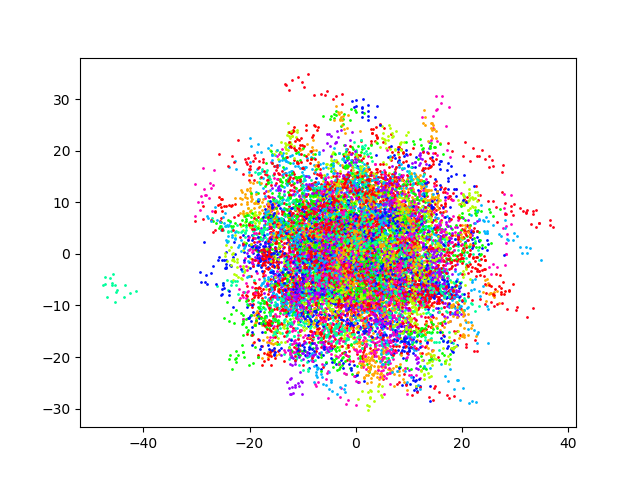

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

num_classes = 10
dataset1, dataset2 = createDatasets(num_classes)

cm = plt.get_cmap('hsv')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(i / (num_classes - 1)) for i in range(num_classes)])
for i in range(len(dataset1)):
    x, y = dataset1[i]
    plt.plot(x[:, 0], x[:, 1], '.', MarkerSize=2)
plt.show()

## Model

Our goal is to learn to classify instances $x$. We do so by estimating the projection of (normalized and mean-shifted) $x$ onto a target sequence $t$ and a classifier that takes the projection vector and outputs the class. The parameters of our model are the target $t$ and parameters of the classifier. The model is implemented below. 

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes=10, dim_features=128, seq_len=16):
        super(Net, self).__init__()
                
        self.lsq = LeastSquaresLayer(beta=1.0e-3, cache_decomposition=False)
        self.t = nn.Parameter(torch.rand(1, 1, seq_len), requires_grad=True)
        self.fc = nn.Linear(dim_features, num_classes)

    def forward(self, x):
        B, T, C = x.shape
        
        # normalize mean-shifted sequence
        x = F.normalize(x - torch.mean(x, dim=2, keepdim=True), dim=1)
        
        # pool across T dimension
        x = x.transpose(1, 2).unsqueeze(3)

        y, y0 = self.lsq(x.view(B, C, T), self.t)
        x = F.normalize(y, dim=1)

        # final classification layer
        x = self.fc(x.flatten(start_dim=1))
        output = F.log_softmax(x, dim=1)
        return output


## Learning

We follow a standard stochastic gradient descent process to learn the parameters, tracking the training set loss, test set accuracy and evolution of target values in parameters $t$.

The code below runs the training process and plots the tracked metrics.

Training............done


<IPython.core.display.Javascript object>


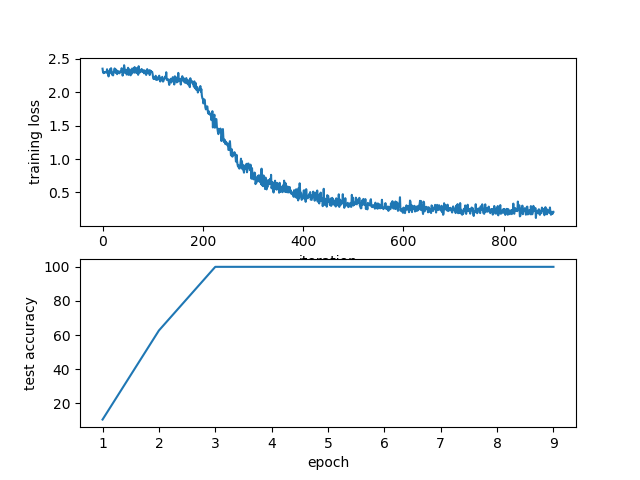

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def train(model, device, train_loader, optimizer):
    model.train()
    loss_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        optimizer.zero_grad()
        loss = F.nll_loss(output, target)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()

    return loss_history
        
def test(model, device, test_loader):
    model.eval()
    loss, correct = 0.0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return loss / len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)


use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.0e-2)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

training_loss, test_accuracy = [], []
target = [model.t.detach().clone().squeeze()]
print("Training...", end='')
for epoch in range(1, 10):
    print(".", end='')
    training_loss += train(model, device, train_loader, optimizer)
    loss, acc = test(model, device, test_loader)
    test_accuracy.append(acc)
    target.append(model.t.detach().clone().squeeze())
    scheduler.step()

print("done")

plt.figure()
plt.subplot(2,1,1); plt.plot(training_loss)
plt.xlabel('iteration'); plt.ylabel('training loss')
plt.subplot(2,1,2); plt.plot(range(1, len(test_accuracy) + 1), test_accuracy)
plt.xlabel('epoch'); plt.ylabel('test accuracy')
plt.show()

We now plot the initial and final values for the target vector. Notice that the final values following a monotonic sequence, which is what we would expect from how the data was constructed.

<IPython.core.display.Javascript object>


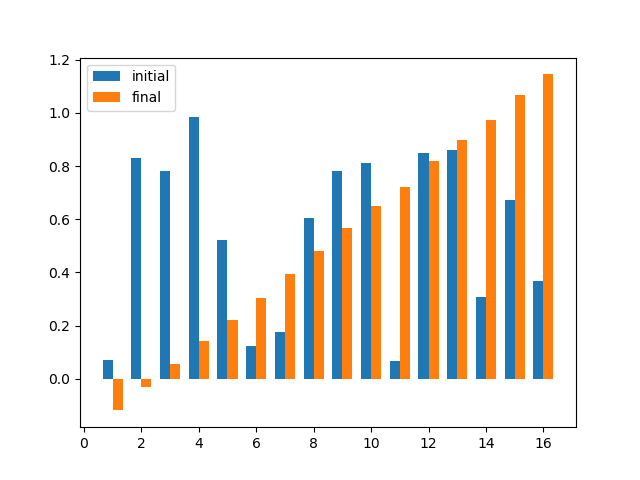

In [6]:
x = torch.linspace(1, len(target[0]), len(target[0]))
width = 0.35

plt.figure()
plt.bar(x - width/2, target[0], width)
plt.bar(x + width/2, target[-1], width)
plt.legend(('initial', 'final'))
plt.show()